In [1]:
pip install gym

Note: you may need to restart the kernel to use updated packages.


In [2]:
import gym
from gym import spaces
import numpy as np
import matplotlib.pyplot as plt
import math
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
actions = ['up','down','left','right','forward','backward','shoot','rotate clockwise on Z','rotate counterclockwise on Z','rotate clockwise on X','rotate counterclockwise on X', 'rotate clockwise on Y','rotate counter-clockwise on Y']
class CustomEnv3D(gym.Env):
    def __init__(self):
        super(CustomEnv3D, self).__init__()
        # Define action and observation spaces
        self.grid_size = 1024
        self.grid = np.zeros((self.grid_size, self.grid_size, self.grid_size, 3), dtype=np.uint8)
        self.action_space = spaces.Discrete(13) 

        self.laction1 = -1
        self.laction2 = -1
        # Initialize agent positions and orientations
        self.agent1_pos = [512, 512, 512]  # Initial position of agent 1
        self.agent2_pos = [256, 256, 256]  # Initial position of agent 2
        self.agent1_facing = [0, 0, 1]  # Initial facing direction of agent 1 (towards positive z-axis)
        self.agent2_facing = [0, 0, -1]  # Initial facing direction of agent 2 (towards negative z-axis)

        self.agent_size = 20

        self.reward1 = 0
        self.reward2 = 0

    def get_direction(self, agentAttacking, agentDefending):
        # Calculate direction from agentAttacking to agentDefending
        diff = np.array(agentDefending) - np.array(agentAttacking)
        return np.degrees(np.arctan2(diff[1], diff[0]))

    def step(self, action1, action2):
        self.reward1 -= 1
        self.reward2 -= 1
        self.laction1 = action1
        self.laction2 = action2

        #Adding premove positions to account for player 1 moving first (so that if P2 shoots they will end up hitting the other agent even if P1 moved first)
        self.agent1_prepos = self.agent1_pos

        # Agent 1 actions
        self._take_action(self.agent1_pos, action1, self.agent1_facing, self.agent2_pos, 1)

        # Agent 2 actions
        self._take_action(self.agent2_pos, action2, self.agent2_facing, self.agent1_prepos, 2)

        # Clip agent positions to stay within the grid boundaries
        self.agent1_pos = np.clip(self.agent1_pos, [0, 0, 0], [1023, 1023, 1023])
        self.agent2_pos = np.clip(self.agent2_pos, [0, 0, 0], [1023, 1023, 1023])

        observation1 = self._get_observation(self.agent1_pos, self.agent2_pos)
        observation2 = self._get_observation(self.agent2_pos, self.agent1_pos)
        done = self.reward1 >= 1000 or self.reward2 >= 1000

        return observation1, observation2, self.reward1, self.reward2, done, {}

    def _take_action(self, agent_pos, action, agent_facing, enemy_pos, agent_number):
        #Readjusting movement speed and size for the 3D map so agents have an easier time getting to one another
        if action == 0:  # Move up
            agent_pos[2] -= 7
        elif action == 1:  # Move down
            agent_pos[2] += 7
        elif action == 2:  # Move left
            agent_pos[1] -= 7
        elif action == 3:  # Move right
            agent_pos[1] += 7
        elif action == 4:  # Move forward
            agent_pos[0] += 7
        elif action == 5:  # Move backward
            agent_pos[0] -= 7
        elif action == 6:  # Shoot
            distancel = self.distance()

            if distancel < 200:  # If distance is less than 100, hit the target
                if agent_number == 1:
                    self.reward1 += 1000  # Reward for agent 1 being hit
                else:
                    self.reward2 += 1000  # Reward for agent 1 being hit
            else:
                if agent_number == 1:
                    self.reward1 -= 1  # Penalty for missing the target
                else:
                    self.reward2 -= 1
        elif action == 7:  # Rotate clockwise along Z
            self.agent2_facing[0] += 10
        elif action == 8:  # Rotate counter-clockwise along Z
            self.agent2_facing[0] -= 10
        elif action == 9:  # Rotate clockwise along X
            self.agent2_facing[1] += 10
        elif action == 10:  # Rotate counter-clockwise along X
            self.agent2_facing[1] -= 10
        elif action == 11:  # Rotate clockwise along Y
            self.agent2_facing[2] += 10
        elif action == 12:  # Rotate counter-clockwise along Y
            self.agent2_facing[2] -= 10
    def distance(self):
        z_diff = self.agent1_pos[0] - self.agent2_pos[0]
        x_diff = self.agent1_pos[1] - self.agent2_pos[1]
        y_diff = self.agent1_pos[2] - self.agent2_pos[2]
        dist = math.sqrt(z_diff**2 + y_diff**2 + x_diff**2)
        return dist
    def _get_observation(self, agent_pos, enemy_pos):
        direction = self.get_direction(agent_pos, enemy_pos)
        distance = np.linalg.norm(np.array(enemy_pos) - np.array(agent_pos))
        return direction, distance

    def reset(self):
        self.agent1_pos = np.random.randint(0, 1025, size=3) 
        self.agent2_pos = np.random.randint(0, 1025, size=3)
        self.agent1_facing = [0, 0, 0]
        self.agent2_facing = [0, 0, 0]
        self.reward1 = 0
        self.reward2 = 0
        return self._get_observation(self.agent1_pos, self.agent2_pos), self._get_observation(self.agent2_pos, self.agent1_pos)



In [4]:
import numpy as np
import random
from collections import deque
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import gym

# Define the neural network architecture
class DQN(nn.Module):
    def __init__(self, input_size, output_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, output_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


# Define the DQN agent
class DQNAgent:
    def __init__(self, state_size, action_size, gamma = 0.95,epsilon = 3.0,epsilon_min=0.01):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = gamma   # discount rate
        self.epsilon = epsilon  # exploration rate
        self.epsilon_min = epsilon_min
        self.epsilon_decay = 0.999
        self.model = DQN(state_size, action_size)
        self.optimizer = optim.Adam(self.model.parameters(), lr=0.1)
        self.loss_fn = nn.MSELoss()

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        state = torch.FloatTensor(state).unsqueeze(0)
        q_values = self.model(state)
        return q_values.argmax().item()

    def replay(self, batch_size):
        if len(self.memory) < batch_size:
            return
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            state = torch.FloatTensor(state).unsqueeze(0)
            next_state = torch.FloatTensor(next_state).unsqueeze(0)
            target = reward
            if not done:
                target = reward + self.gamma * torch.max(self.model(next_state)).item()
            target_f = self.model(state).squeeze(0).tolist()
            target_f[action] = target
            target_f = torch.FloatTensor(target_f)
            self.optimizer.zero_grad()
            loss = self.loss_fn(self.model(state).squeeze(0), target_f)
            loss.backward()
            self.optimizer.step()
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

In [7]:
import tensorflow as tf
# Create the custom environment
env = CustomEnv3D()

# Set the state and action sizes
state_size = 2 # Assuming each agent's observation is a tuple of (direction, distance)
action_size = 13  # Number of actions available to each agent
epsilons = [0.5, 1.0, 2.0, 3.0]
gammas = [0.95, 0.99]

#Saving lists of lists of data to report later from each loop
agg_rewards1 = []
agg_rewards2 = []
scores1 = []
scores2 = []
epsilon_changes = []

target_device = "/device:GPU:0"

with tf.device(target_device):
    # Create two DQN agents
    for epsilon in epsilons:
        for gamma in gammas:
            agent1 = DQNAgent(state_size, action_size, gamma= gamma, epsilon=epsilon)
            agent2 = DQNAgent(state_size, action_size, gamma= gamma, epsilon=epsilon)

            #Some hyperparameters for the training loop
            batch_size = 32
            episodes = 10000
            num_steps = 500

            #Aggregating rewards to report during loop
            agg_reward1 = 0
            agg_reward2 = 0

            for e in range(episodes):
                temp_scores1 = []
                temp_scores2 = []
                temp_agg_reward1 = []
                temp_agg_reward2 = []
                temp_epsilon_changes = []
                # Reset the environment
                state1, state2 = env.reset()

                for time in range(num_steps):  # Limiting the episode length
                    # Agents take actions
                    action1 = agent1.act(state1)
                    action2 = agent2.act(state2)
                    next_state1, next_state2, reward1, reward2, done, _ = env.step(action1, action2)
                
                    # Remember the previous state, action, reward, and next state
                    agent1.remember(state1, action1, reward1, next_state1, done)
                    agent2.remember(state2, action2, reward2, next_state2, done)
                    
                    # Update the current state
                    state1 = next_state1
                    state2 = next_state2

                    if done or time == num_steps - 1:
                        agg_reward1 += reward1
                        agg_reward2 += reward2
                        temp_scores1.append(reward1)
                        temp_scores2.append(reward2)
                        temp_agg_reward1.append(agg_reward1)
                        temp_agg_reward2.append(agg_reward2)
                        temp_epsilon_changes.append(epsilon)
                        print("episode: {}/{}, score1: {}, score2: {}, e: {:.2}, P1's aggregated rewards: {}, P2's aggregated rewards: {}"
                            .format(e, episodes, reward1, reward2, agent1.epsilon, agg_reward1, agg_reward2))
                        break

                # Replay to train the agents
                if len(agent1.memory) > batch_size:
                    agent1.replay(batch_size)
                if len(agent2.memory) > batch_size:
                    agent2.replay(batch_size)
            agg_rewards1.append(temp_agg_reward1)
            agg_rewards2.append(temp_agg_reward2)
            scores1.append(temp_scores1)
            scores2.append(temp_scores2)
            epsilon_changes.append(temp_epsilon_changes)

episode: 0/10000, score1: -520, score2: -520, e: 0.5, P1's aggregated rewards: -520, P2's aggregated rewards: -520
episode: 1/10000, score1: -520, score2: -528, e: 0.5, P1's aggregated rewards: -1040, P2's aggregated rewards: -1048
episode: 2/10000, score1: -521, score2: -521, e: 0.5, P1's aggregated rewards: -1561, P2's aggregated rewards: -1569
episode: 3/10000, score1: -525, score2: -521, e: 0.5, P1's aggregated rewards: -2086, P2's aggregated rewards: -2090
episode: 4/10000, score1: 894, score2: 1894, e: 0.5, P1's aggregated rewards: -1192, P2's aggregated rewards: -196
episode: 5/10000, score1: -774, score2: -519, e: 0.5, P1's aggregated rewards: -1966, P2's aggregated rewards: -715
episode: 6/10000, score1: -517, score2: -517, e: 0.5, P1's aggregated rewards: -2483, P2's aggregated rewards: -1232
episode: 7/10000, score1: -514, score2: -514, e: 0.5, P1's aggregated rewards: -2997, P2's aggregated rewards: -1746
episode: 8/10000, score1: -518, score2: -515, e: 0.5, P1's aggregated

KeyboardInterrupt: 

In [10]:
def visualize_q_map(model):
    direction_values = list(range(360))
    distance_values = list(range(1024))
    colors = [
    'blue',         # Blue
    'orange',       # Orange
    'green',        # Green
    'red',          # Red
    'purple',       # Purple
    'brown',        # Brown
    'pink',         # Pink
    'gray',         # Gray
    'olive',        # Olive
    'cyan',         # Cyan
    'magenta',      # Magenta
    'lime',         # Lime
    'teal'          # Teal 
    ]
    fig = plt.figure(dpi=200,figsize=(8, 8))
    ax = fig.add_subplot(projection='polar')
    for direction in direction_values:
        radians = np.deg2rad(direction)
        for distance in distance_values:
            state = (direction, distance)
            q_values = model.act(state)      
            plt.polar(radians, distance,marker=',', color=colors[q_values])

    ax.set_theta_direction(-1)  # Set clockwise direction
    ax.set_theta_zero_location("N")  # Set zero degrees at the top
    plt.title('Polar Distance vs. Degree by Actions')
    plt.show()

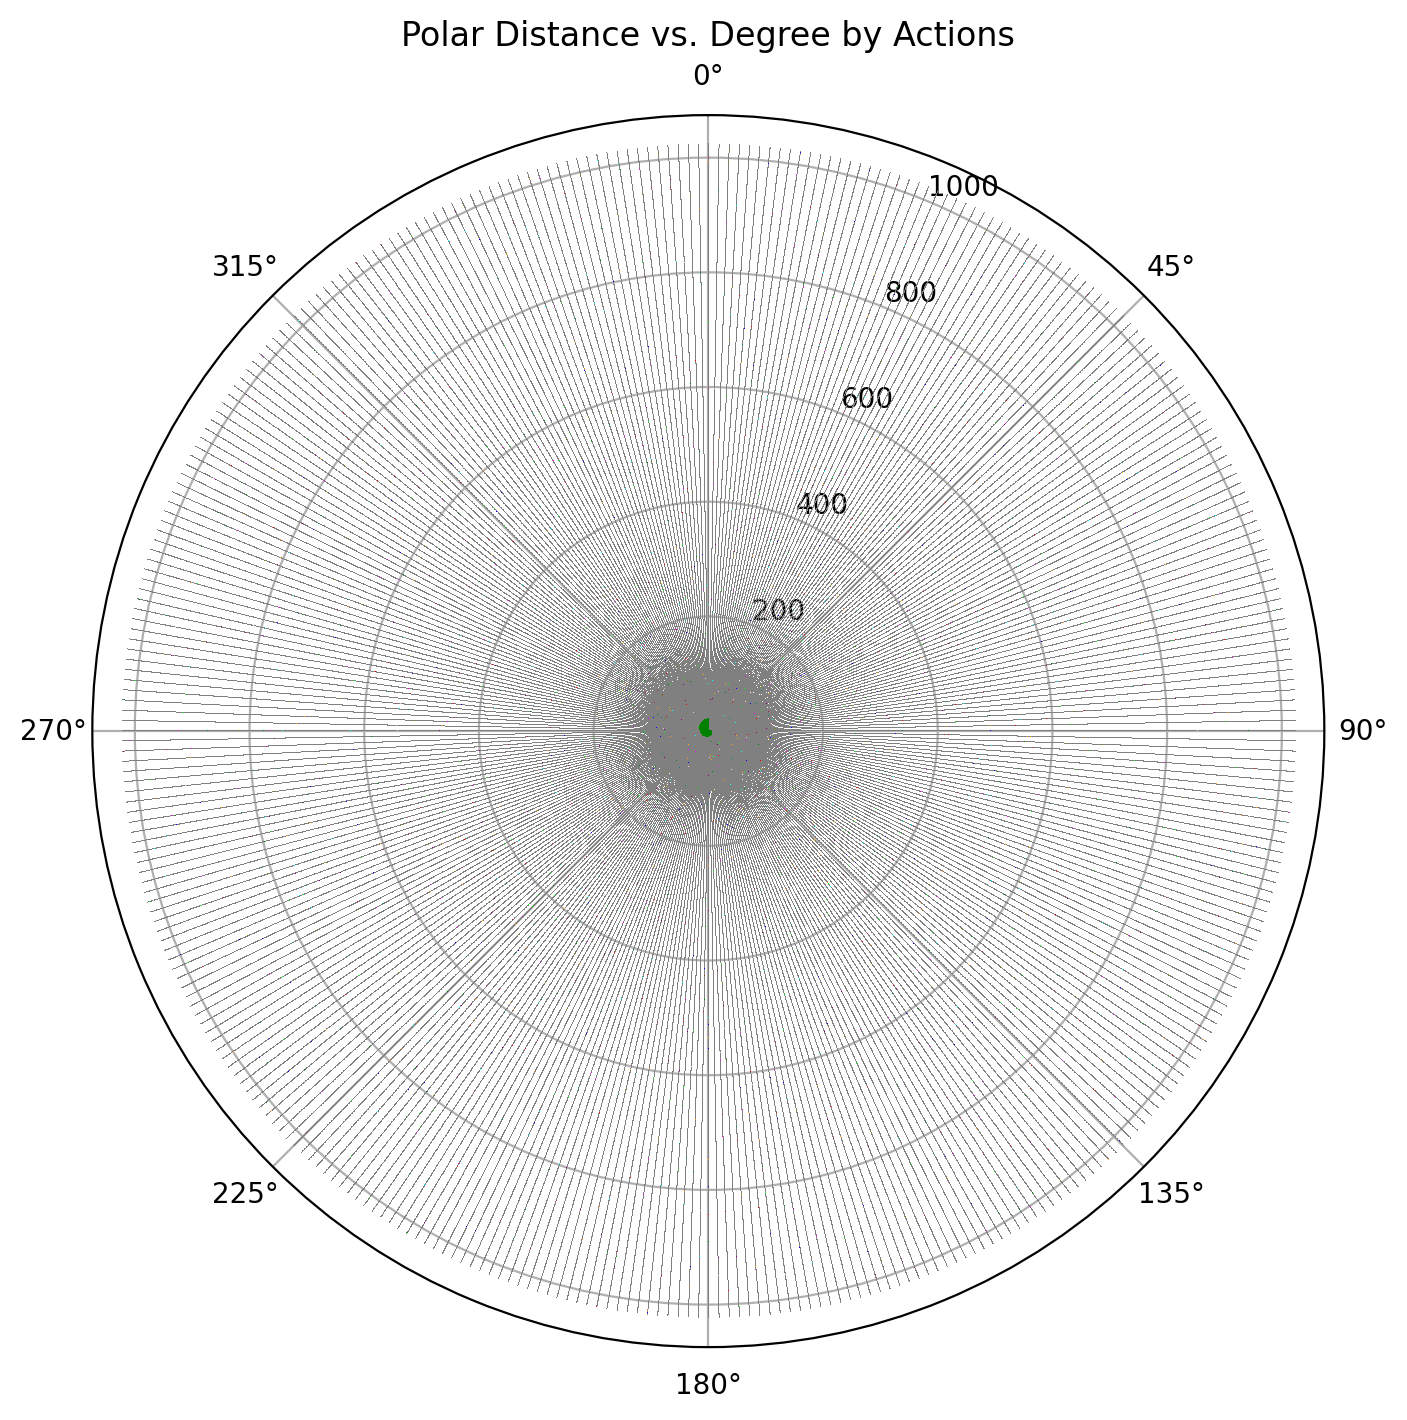

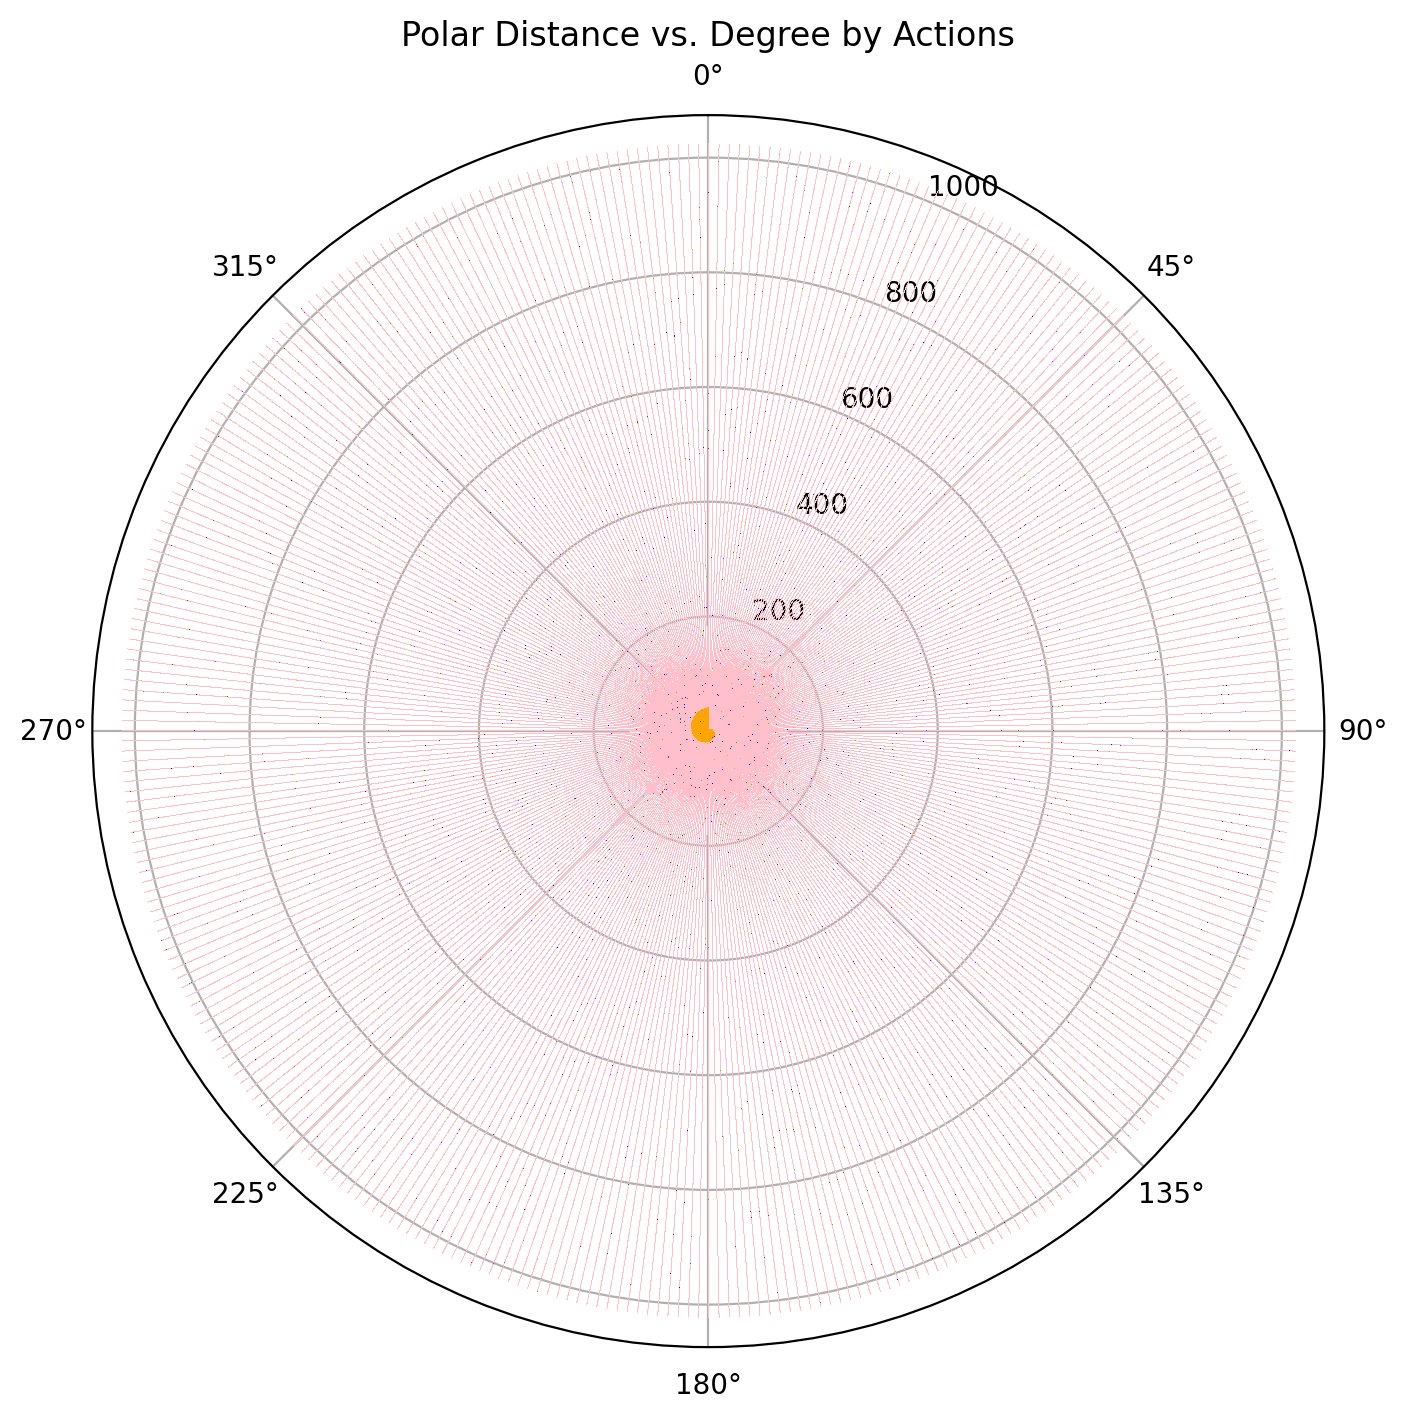

In [11]:
visualize_q_map(agent1)
visualize_q_map(agent2)